# Geometry Extraction Sanity Checks (v2)

This notebook validates the **updated** image analysis pipeline for Week 2.
Key improvements:
- **Arm Detection**: Angle clustering (histogram peaks) instead of connected components.
- **Spiral Fitting**: Robust linear regression on unwrapped angles per arm.


In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io, color
from scipy import signal

# Add repo root to path
current_dir = Path(os.getcwd())
if current_dir.name == 'notebooks':
    repo_root = current_dir.parent
else:
    repo_root = current_dir

sys.path.append(str(repo_root))

from src.geometry import (
    load_image_gray, binary_mask, extract_boundary, skeletonize_boundary,
    estimate_center, detect_arms_by_angle, fit_log_spiral_for_arm,
    box_count_fractal_dimension, analyze_spiral_image, polar_coords_from_center
)

# Setup plotting
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print(f"Repo root: {repo_root}")


Repo root: /Users/charannagaram/spiral_fractals


## 1. Load Sample Images
We'll load the high-quality showcase spirals.


Loaded tight_2arm_additive.png
Loaded loose_2arm_additive.png
Loaded tight_3arm_additive.png
Loaded loose_3arm_additive.png
Loaded dense_4arm_additive.png


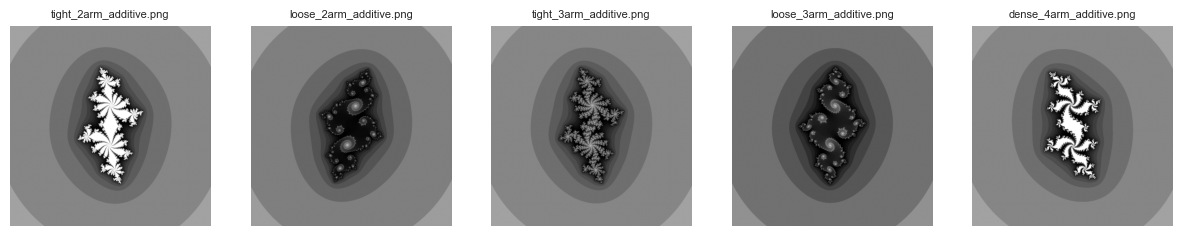

In [2]:
image_dir = repo_root / 'figures' / 'best'
sample_filenames = [
    'tight_2arm_additive.png',
    'loose_2arm_additive.png',
    'tight_3arm_additive.png',
    'loose_3arm_additive.png',
    'dense_4arm_additive.png'
]

images = {}
for fname in sample_filenames:
    path = image_dir / fname
    if path.exists():
        images[fname] = load_image_gray(path)
        print(f"Loaded {fname}")
    else:
        print(f"Warning: {fname} not found")

# Visualize
fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
if len(images) == 1: axes = [axes]
for ax, (fname, img) in zip(axes, images.items()):
    ax.imshow(img, cmap='gray')
    ax.set_title(fname, fontsize=8)
    ax.axis('off')
plt.show()


## 2. Preprocessing
Generate binary masks and skeletons.


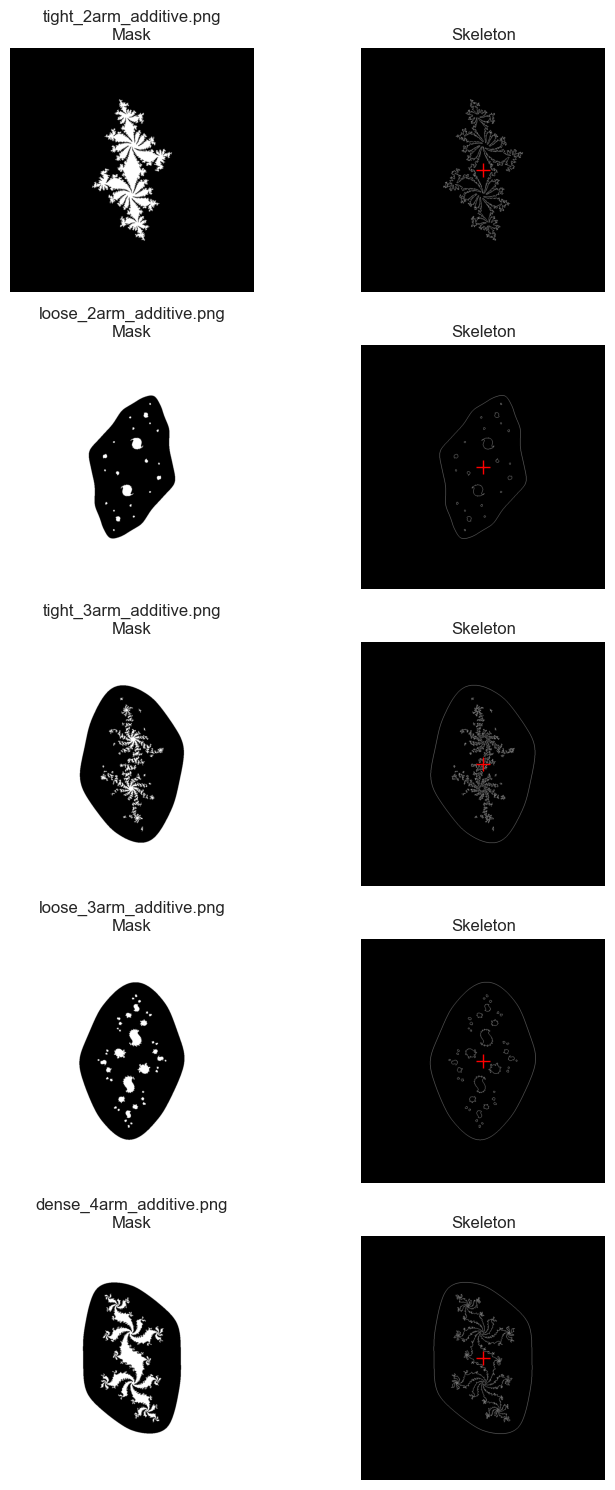

In [3]:
skeletons = {}
centers = {}

fig, axes = plt.subplots(len(images), 2, figsize=(8, 3*len(images)))

for i, (fname, img) in enumerate(images.items()):
    # Pipeline steps
    mask = binary_mask(img)
    boundary = extract_boundary(mask)
    skel = skeletonize_boundary(boundary)
    center = estimate_center(mask)
    
    skeletons[fname] = skel
    centers[fname] = center
    
    # Plot Mask
    axes[i, 0].imshow(mask, cmap='gray')
    axes[i, 0].set_title(f"{fname}\nMask")
    axes[i, 0].axis('off')
    
    # Plot Skeleton + Center
    axes[i, 1].imshow(skel, cmap='gray')
    axes[i, 1].plot(center[0], center[1], 'r+', markersize=10, label='Center')
    axes[i, 1].set_title("Skeleton")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


## 3. Arm Detection (Angle Clustering)
We detect arms by looking for peaks in the angular histogram of skeleton pixels.


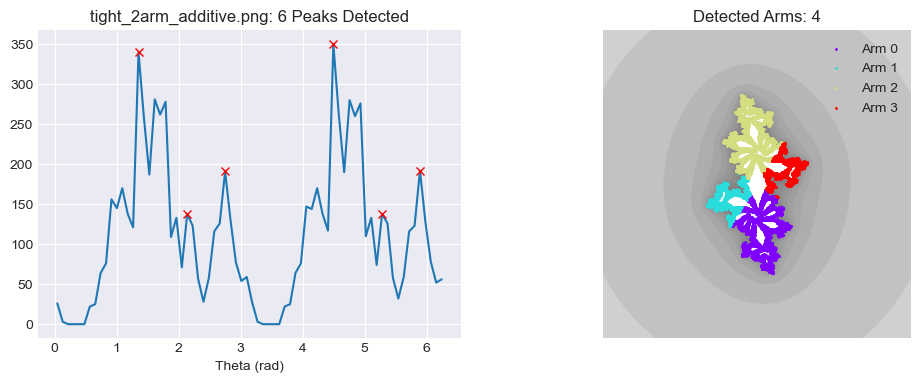

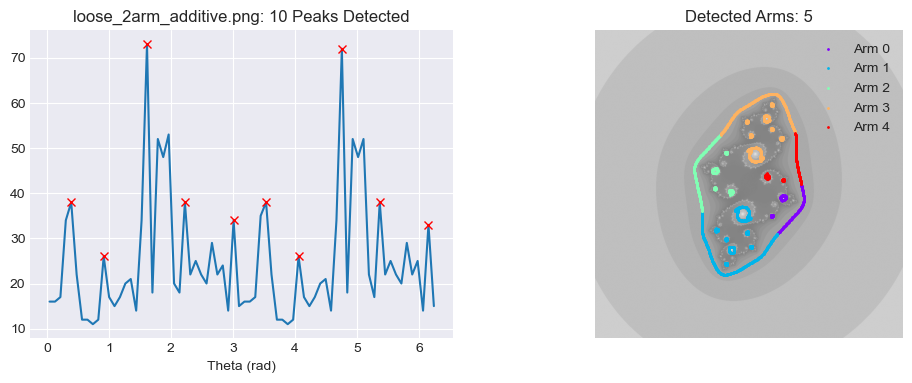

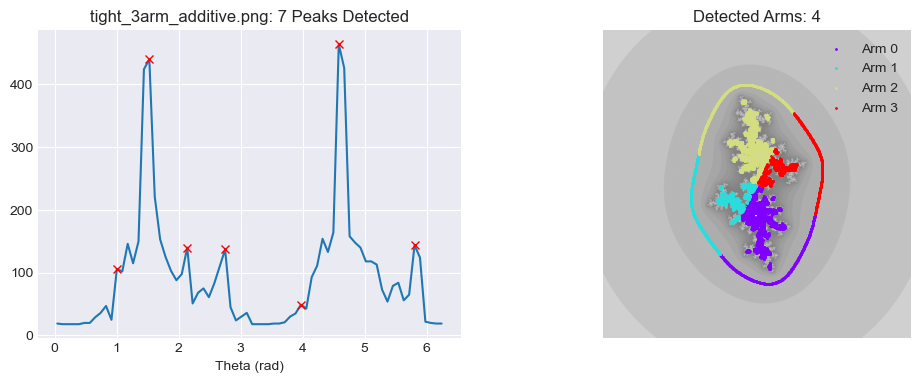

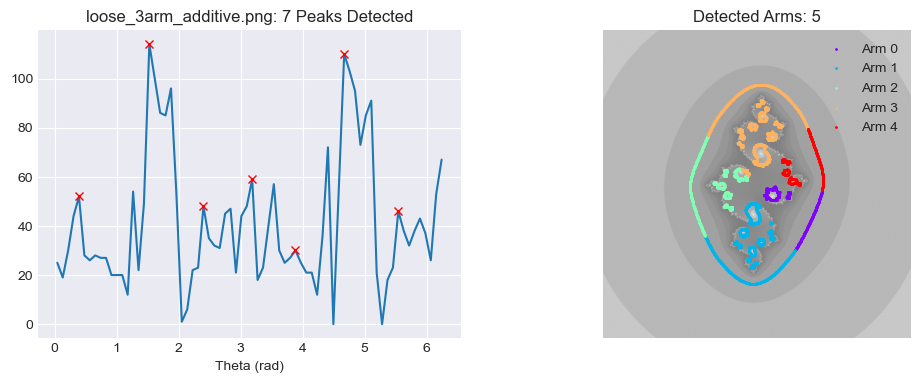

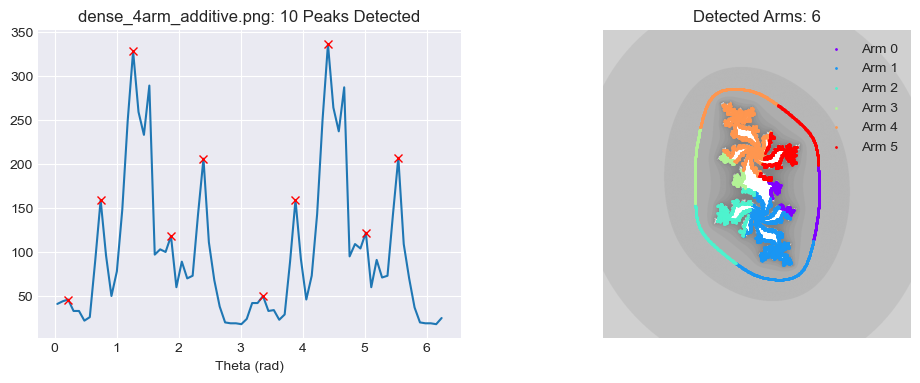

In [4]:
for fname, skel in skeletons.items():
    center = centers[fname]
    
    # 1. Get polar coords of skeleton
    y, x = np.where(skel)
    points = np.column_stack((y, x))
    r, theta = polar_coords_from_center(points, center)
    
    # 2. Histogram
    # Filter mid-radius for cleaner histogram
    r_max = r.max()
    mask_band = (r > 0.2 * r_max) & (r < 0.8 * r_max)
    theta_band = np.mod(theta[mask_band], 2*np.pi)
    
    hist, bin_edges = np.histogram(theta_band, bins=72, range=(0, 2*np.pi))
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find peaks (using same logic as src/geometry.py)
    peaks, _ = signal.find_peaks(hist, height=0.05*hist.max(), distance=72//12)
    
    # Detect arms using the function
    arms = detect_arms_by_angle(skel, center)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    # Histogram
    ax1.plot(bin_centers, hist)
    ax1.plot(bin_centers[peaks], hist[peaks], "x", color='r')
    ax1.set_title(f"{fname}: {len(peaks)} Peaks Detected")
    ax1.set_xlabel("Theta (rad)")
    
    # Colored Arms
    ax2.imshow(images[fname], cmap='gray', alpha=0.5)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(arms)))
    for arm_idx, arm_pixels in enumerate(arms):
        ax2.scatter(arm_pixels[:, 1], arm_pixels[:, 0], s=1, color=colors[arm_idx], label=f"Arm {arm_idx}")
    ax2.set_title(f"Detected Arms: {len(arms)}")
    ax2.legend()
    ax2.axis('off')
    
    plt.show()


## 4. Log-Spiral Fitting
Fit $ \ln(r) = b \theta + \ln(a) $ to each detected arm.


--- tight_2arm_additive.png ---
Arm 0: b=3.165, R2=0.206, n=1014
Arm 1: b=-2.423, R2=0.115, n=401
Arm 2: b=2.992, R2=0.188, n=993
Arm 3: b=-1.749, R2=0.054, n=406


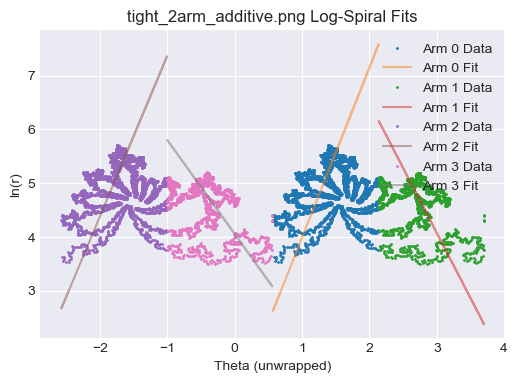

--- loose_2arm_additive.png ---
Arm 0: b=0.020, R2=0.060, n=164
Arm 1: b=0.016, R2=0.015, n=230
Arm 2: b=0.063, R2=0.502, n=254
Arm 3: b=-4.002, R2=0.360, n=228
Arm 4: b=-1.016, R2=0.912, n=89


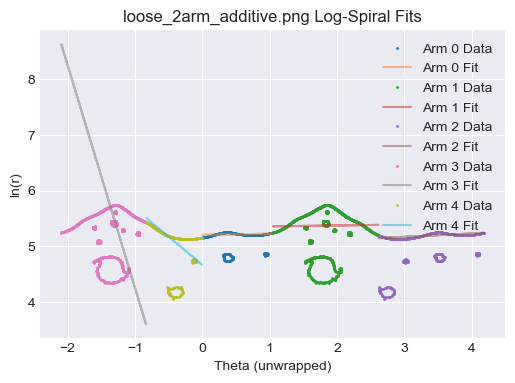

--- tight_3arm_additive.png ---
Arm 0: b=-0.327, R2=0.001, n=1089
Arm 1: b=2.158, R2=0.905, n=366
Arm 2: b=2.991, R2=0.129, n=1114
Arm 3: b=2.080, R2=0.915, n=398


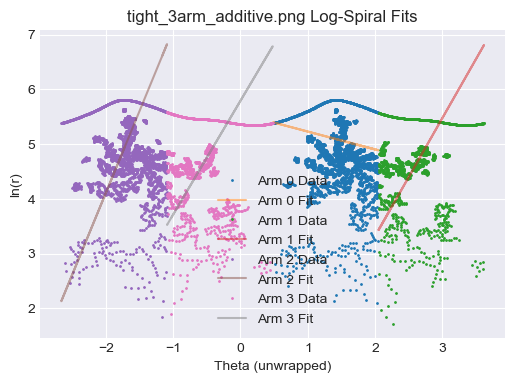

--- loose_3arm_additive.png ---
Arm 0: b=5.352, R2=0.381, n=129
Arm 1: b=-3.359, R2=0.795, n=384
Arm 2: b=-0.883, R2=0.968, n=186
Arm 3: b=4.308, R2=0.415, n=392
Arm 4: b=-1.251, R2=0.913, n=140


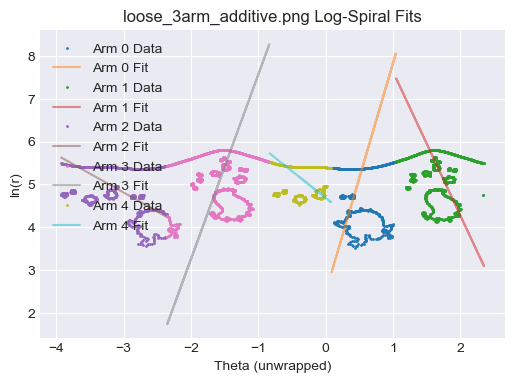

--- dense_4arm_additive.png ---
Arm 0: b=2.379, R2=0.951, n=187
Arm 1: b=-3.817, R2=0.286, n=932
Arm 2: b=-1.791, R2=0.070, n=410
Arm 3: b=2.384, R2=0.957, n=179
Arm 4: b=-4.136, R2=0.404, n=953
Arm 5: b=-3.193, R2=0.411, n=412


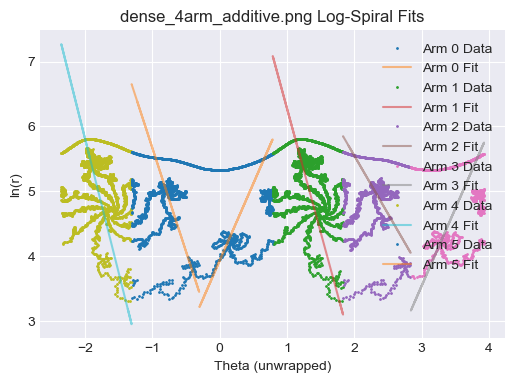

In [5]:
for fname, skel in skeletons.items():
    center = centers[fname]
    arms = detect_arms_by_angle(skel, center)
    
    print(f"--- {fname} ---")
    
    fig, ax = plt.subplots(figsize=(6, 4))
    
    for i, arm_pixels in enumerate(arms):
        res = fit_log_spiral_for_arm(arm_pixels, center)
        
        if res['valid']:
            print(f"Arm {i}: b={res['b']:.3f}, R2={res['r2']:.3f}, n={res['n_points']}")
            
            # Plot data
            r, theta = polar_coords_from_center(arm_pixels, center)
            # Sort for plotting
            idx = np.argsort(r)
            r = r[idx]
            theta = theta[idx]
            theta_unwrap = np.unwrap(theta)
            
            ax.plot(theta_unwrap, np.log(r), '.', markersize=2, label=f"Arm {i} Data")
            
            # Plot fit
            # y = b * theta + intercept
            # intercept is ln(a)
            fit_y = res['b'] * theta_unwrap + res['intercept']
            
            ax.plot(theta_unwrap, fit_y, '-', alpha=0.5, label=f"Arm {i} Fit")
            
    ax.set_xlabel("Theta (unwrapped)")
    ax.set_ylabel("ln(r)")
    ax.set_title(f"{fname} Log-Spiral Fits")
    ax.legend()
    plt.show()


## 5. Full Pipeline Summary
Run `analyze_spiral_image` on all samples and report metrics.


In [6]:
results = []

for fname in sample_filenames:
    path = image_dir / fname
    if not path.exists(): continue
        
    metrics = analyze_spiral_image(path)
    metrics['image'] = fname
    results.append(metrics)

df = pd.DataFrame(results)
cols = ['image', 'arm_count', 'b_mean', 'r2_mean', 'fractal_dimension']
display(df[cols])

print("\nDetailed Metrics:")
display(df)


,image,arm_count,b_mean,r2_mean,fractal_dimension
0,tight_2arm_additive.png,0.0,NaN,NaN,1.528251
1,loose_2arm_additive.png,3.0,1.335024,0.731512,0.987735
2,tight_3arm_additive.png,2.0,2.794709,0.901088,1.322316
3,loose_3arm_additive.png,3.0,2.210045,0.870548,1.061567
4,dense_4arm_additive.png,3.0,2.193022,0.885305,1.326936



Detailed Metrics:


,arm_count,b_mean,b_std,r2_mean,fractal_dimension,fractal_dimension_ci_low,fractal_dimension_ci_high,image
0,0.0,NaN,NaN,NaN,1.528251,1.463312,1.468236,tight_2arm_additive.png
1,3.0,1.335024,1.265340,0.731512,0.987735,0.921687,0.936672,loose_2arm_additive.png
2,2.0,2.794709,0.066902,0.901088,1.322316,1.261285,1.265396,tight_3arm_additive.png
3,3.0,2.210045,1.826258,0.870548,1.061567,0.993803,1.000783,loose_3arm_additive.png
4,3.0,2.193022,0.480738,0.885305,1.326936,1.263452,1.269044,dense_4arm_additive.png
